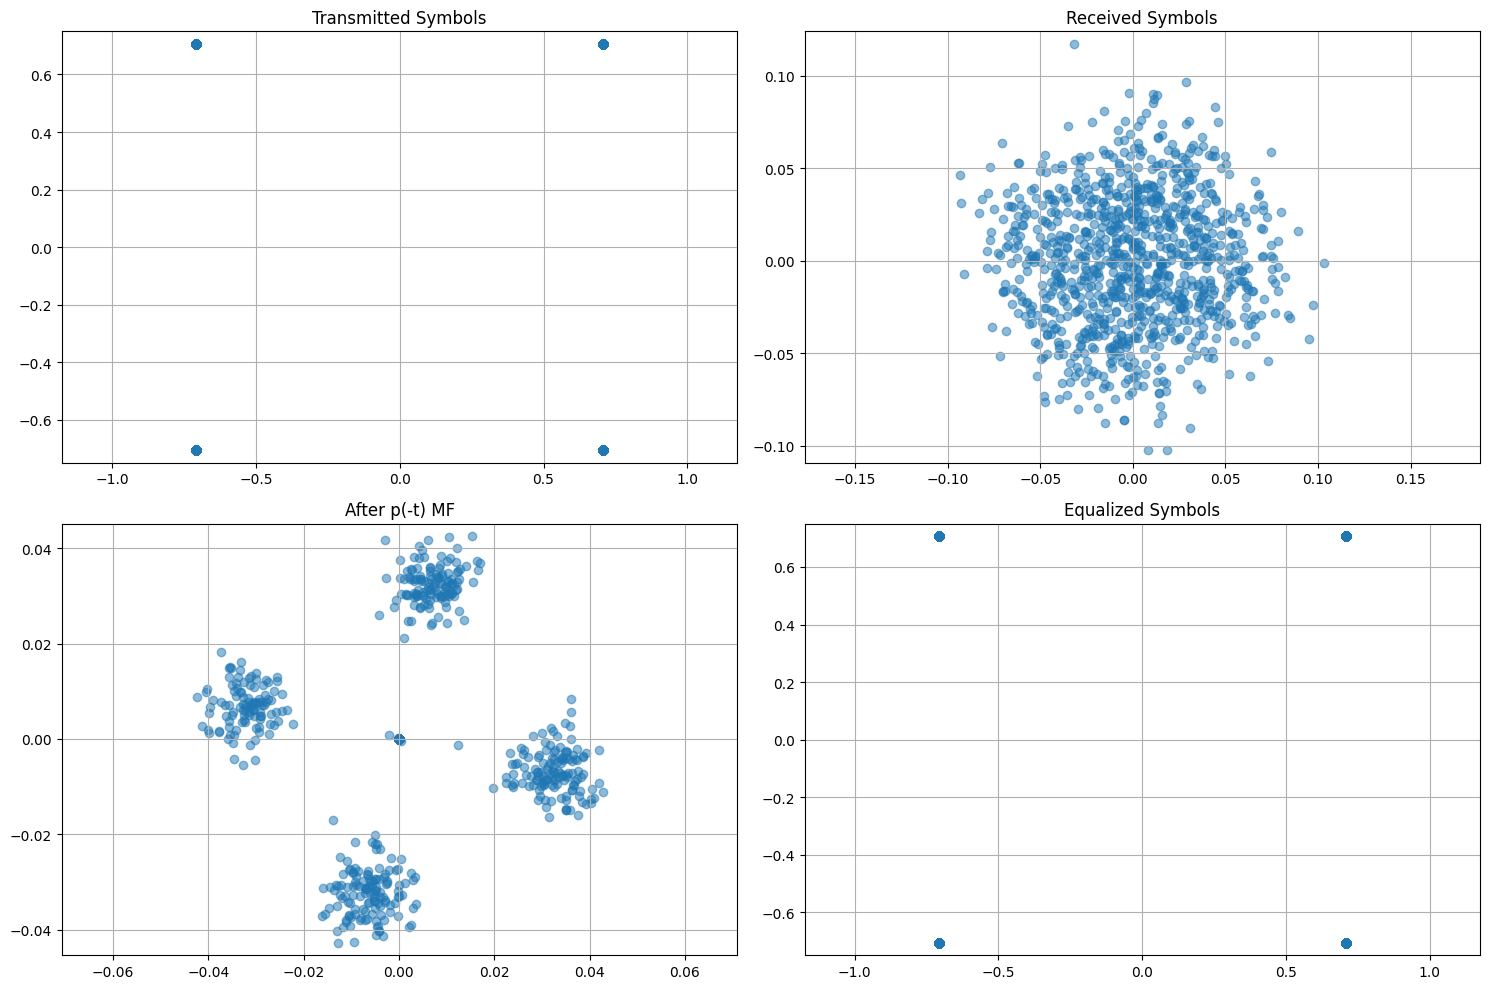

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def root_raised_cosine(t, T, beta=0.35):
    with np.errstate(divide='ignore', invalid='ignore'):
        # Handle special cases where the denominator is zero
        h = np.where(np.abs(4 * beta * t / T) == 1.0,
                     (beta / np.sqrt(2 * T)) * ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) + (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta))),
                     np.where(t == 0,
                              (1 / np.sqrt(T)) * (1 + beta * (4 / np.pi - 1)),
                              (np.sqrt(1/T)/(np.pi * t / T * (1 - (4 * beta * t / T)**2))) * (np.sin(np.pi * t / T * (1 - beta)) + 4 * beta * t / T * np.cos(np.pi * t / T * (1 + beta)))))
    return h

# Parameters
T = 1
n_symbols = 1000
samples_per_symbol = 32
t = np.linspace(-4*T, (n_symbols+4)*T, n_symbols*samples_per_symbol)
dt = t[1] - t[0]

# 4-QAM constellation
qam_const = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
symbols = qam_const[np.random.randint(0, 4, n_symbols)]

# Transmit signal with RRC
beta = 0.35
p_t = root_raised_cosine(t, T, beta)
tx_signal = np.zeros(len(t), dtype=complex)
for k, sk in enumerate(symbols):
    tx_signal += sk * np.roll(p_t, k*samples_per_symbol)

# Channel
channel_taps = 5
channel = np.random.randn(channel_taps) + 1j * np.random.randn(channel_taps)
channel = channel / np.linalg.norm(channel)  # Normalize channel energy

# Received signal
rx_signal = np.convolve(tx_signal, channel, 'same') * dt

# Add noise
snr_db = 0
signal_power = np.mean(np.abs(rx_signal)**2)
noise_power = signal_power / (10**(snr_db/10))
noise = np.sqrt(noise_power/2) * (np.random.randn(len(rx_signal)) + 1j*np.random.randn(len(rx_signal)))
rx_signal += noise

# Receiver matched filter (RRC)
p_r = np.conj(np.flip(p_t)) # matched filter is time-reversed complex conjugate of p_t
mf_p_out = np.convolve(rx_signal, p_r, 'same') * dt

# Sample outputs
offset = 4*samples_per_symbol
sample_points = np.arange(offset, len(t)-offset, samples_per_symbol)
rx_sampled = rx_signal[sample_points]
mf_p_sampled = mf_p_out[sample_points]

# Equalization based on the equation
L = len(channel)  # Length of the channel
equalized_symbols = np.zeros(len(mf_p_sampled) - L + 1, dtype=complex)

for n in range(len(equalized_symbols)):
  min_metric = np.inf
  best_symbol = None

  for s_n in qam_const:
      metric = 0

      for i in range(L):
          z_ni = mf_p_sampled[n + i]
          h_sum = 0

          for k in range(L):
            if n + i - k >= 0 and n + i - k < len(equalized_symbols):
              s_ni_k = equalized_symbols[n + i - k] if n + i - k < n else s_n
              h_sum += channel[k] * s_ni_k

          metric += (np.abs(z_ni - h_sum)) ** 2

      if metric < min_metric:
          min_metric = metric
          best_symbol = s_n

  equalized_symbols[n] = best_symbol

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.scatter(symbols.real, symbols.imag, alpha=0.5)
plt.title('Transmitted Symbols')
plt.grid(True)
plt.axis('equal')

plt.subplot(222)
plt.scatter(rx_sampled.real, rx_sampled.imag, alpha=0.5)
plt.title('Received Symbols')
plt.grid(True)
plt.axis('equal')

plt.subplot(223)
plt.scatter(mf_p_sampled.real, mf_p_sampled.imag, alpha=0.5)
plt.title('After p(-t) MF')
plt.grid(True)
plt.axis('equal')

plt.subplot(224)
plt.scatter(equalized_symbols.real, equalized_symbols.imag, alpha=0.5)
plt.title('Equalized Symbols')
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()